In [ ]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages')
import requests, re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime
import talib
import math
import matplotlib.pyplot as plt
from datetime import date

In [2]:
def get_candle_df(df , frequency):
    c=pd.DataFrame()
    c['candle_close']=df.Close.shift(-1).resample(frequency).last().dropna()
    c['candle_open']=df.Open.shift(-1).resample(frequency).first().dropna()
    c['candle_high']=df.High.shift(-1).resample(frequency).max().dropna()
    c['candle_low']=df.Low.shift(-1).resample(frequency).min().dropna()
    c['candle_volume']=df.Volume.shift(-1).resample(frequency).sum().dropna()
    c['rsi'] = df.resample(frequency , convention = 'end').asfreq().rsi
    
    return c

In [3]:
def BBand(df, base='candle_close', period=5, multiplier=3):
 
    upper = 'BB_' + str(period) + '_' + str(multiplier)
    #lower = 'LowerBB_' + str(period) + '_' + str(multiplier)
    
    sma = df[base].rolling(window=period, min_periods=period - 1).mean()
    sd = df[base].rolling(window=period).std()
    df[upper] = sma + (multiplier * sd)
    #df[lower] = sma - (multiplier * sd)
    
    df[upper].fillna(0, inplace=True)
    #df[lower].fillna(0, inplace=True)
    
    return df

# use multiplier +1 for upper and -1 for lower

In [4]:
tickers = pd.read_csv(r'A:/finance_stuff/nifty_100/ind_nifty100list.csv')['Symbol'].to_list()

In [5]:
def df_setup(ticker):
    df=pd.read_csv(r'A:\finance_stuff\Intraday_Data\\' + str(ticker) + '.csv')
     #datetime
    rsi = talib.RSI(df.Close , timeperiod =60)
    df['rsi'] = rsi
        
    df['Time']=pd.to_datetime(df['Time'].apply(lambda x: x.split('+')[0]))
    df.set_index('Time',inplace=True)
     #candle
    candle_df = get_candle_df(df,'3T')
    #BB data
    bb_df = BBand(candle_df, period = 100 , multiplier = 0)
    bb_df = BBand(candle_df, period = 100, multiplier = 1)
    bb_df = BBand(candle_df, period = 100, multiplier = 2)
    bb_df = BBand(candle_df, period = 100, multiplier = -1)
    bb_df = BBand(candle_df, period = 100, multiplier = -2)
    
    bb_df.dropna(inplace = True)
    
    return bb_df

In [6]:
def BB_tradebook(df):
    data = df
    result = df
    
    trade_book_long={}
    trade_book_short={}
    position=0
    sl=0.0025
    tp=0.005
    p=0
    entry_price=0
    entry_price_s=0
    exit_price=0
    exit_price_s=0
   
    for i in range(101, len(data.index)):
        if ((position == 0)&(result.loc[ data.index[i-1] ,'rsi'] > 50 )
            &(result.loc[ data.index[i-1] ,'candle_high']>result.loc[data.index[i-1],'BB_100_1'])
            &(result.loc[ data.index[i-1] ,'candle_low']<result.loc[data.index[i-1],'BB_100_2'])):
            
            rsi = result.loc[ data.index[i] ,'rsi']
            position=1
            time=data.index[i]
            entry_time_l=time
            print('position entered at {}'.format(time))
    #             x.at[i,'position']=1
            entry_price=data.loc[data.index[i],'candle_open']
            #print(entry_price)
        elif ((position == 0)&(result.loc[ data.index[i-1] ,'rsi'] < 50 ) 
              &(result.loc[ data.index[i-1] ,'candle_low']<result.loc[data.index[i-1],'BB_100_-1'])
              &(result.loc[ data.index[i-1] ,'candle_high']>result.loc[data.index[i-1],'BB_100_-2'])):
            
            
            rsi = result.loc[ data.index[i] ,'rsi']
            position=-1
            time_s=data.index[i]
            entry_time_s=time_s
            print('short position entered at {}'.format(time_s))
    #             x.at[i,'position']=1
            entry_price_s=data.loc[data.index[i],'candle_open']
            #print(entry_price_s)
        elif ((position == 1)&(result.loc[ data.index[i-1] ,'candle_low']>result.loc[data.index[i-1],'BB_100_2'])):

            position=0
            time=data.index[i]
            print('long position exited at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price=data.loc[data.index[i],'candle_open']
            profit=exit_price-entry_price
            exit_time=time
            trade_book_long[entry_time_l]=[entry_price,exit_price,profit,exit_time,rsi,'LONG']
            #print(exit_price)        
            #print(profit)
            
        elif ((position == 1)&((result.loc[ data.index[i-1] ,'candle_low']<result.loc[data.index[i-1],'BB_100_0']) |
                              (result.loc[ data.index[i-1] ,'candle_low'] < (entry_price*.99) ))):

            position=0
            time=data.index[i]
            print('long position stop loss at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price=data.loc[data.index[i],'candle_open']
            profit=exit_price-entry_price
            exit_time=time
            trade_book_long[entry_time_l]=[entry_price,exit_price,profit,exit_time,rsi,'LONG']
            #print(exit_price)        
            #print(profit)
            
        elif ((position == -1)&(result.loc[ data.index[i-1] ,'candle_high']<result.loc[data.index[i-1],'BB_100_-2'])):
            
            position=0
            time=data.index[i]
            print('short position exited at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price_s=data.loc[data.index[i],'candle_open']
            profit=entry_price_s-exit_price_s
            exit_time_s=time
            trade_book_short[entry_time_s]=[entry_price_s,exit_price_s,profit,exit_time_s,rsi,'SHORT']
            #print(exit_price_s)        
            #print(profit)
        
        elif ((position == -1)&((result.loc[ data.index[i-1] ,'candle_high']>result.loc[data.index[i-1],'BB_100_0'])|
                               (result.loc[ data.index[i-1] ,'candle_high'] > (entry_price_s*1.01)))):
            
            position=0
            time=data.index[i]
            print('short position stop loss at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price_s=data.loc[data.index[i],'candle_open']
            profit=entry_price_s-exit_price_s
            exit_time_s=time
            trade_book_short[entry_time_s]=[entry_price_s,exit_price_s,profit,exit_time_s,rsi,'SHORT']
            #print(exit_price_s)        
            #print(profit)
            
        elif ((position==1)&(data.index[i].time()==datetime.time(15, 27))):
            position=0
            time=data.index[i]
            print('long position covered at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price=data.loc[data.index[i],'candle_close']
            profit=exit_price-entry_price
            exit_time=time
            trade_book_long[entry_time_l]=[entry_price,exit_price,profit,exit_time,rsi,'LONG']
            #print(exit_price)
            #print(profit)
        elif ((position==-1)&(data.index[i].time()==datetime.time(15, 27))):
            position=0
            time=data.index[i]
            print('short position covered at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price_s=data.loc[data.index[i],'candle_close']
            profit=entry_price_s-exit_price_s
            exit_time_s=time
            trade_book_short[entry_time_s]=[entry_price_s,exit_price_s,profit,exit_time_s,rsi,'SHORT']
            #print(exit_price_s)
            #print(profit)
    s1=pd.DataFrame(trade_book_long).T
    s2 = pd.DataFrame(trade_book_short).T
    
    df1 = pd.concat([s1,s2])
    
    df1.sort_index(inplace = True)
    return df1

In [7]:
def get_pl(df):  
    money = 100000
    pl = []
    for i in df.index:
        a1 = math.floor(money/df[0][i])
        money = money + (a1*df[2][i])
        pl.append(money)
    return pl

In [8]:
def BB_strat_backtest(ticker):
    df = df_setup(ticker)
    df = BB_tradebook(df)
    a1 = get_pl(df)
    
    df['money'] = a1
    
    df.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str(ticker) + '_BB.csv')
    
    return df

In [9]:
df = BB_strat_backtest('HDFC')

short position entered at 2018-12-04 09:15:00
short position exited at 2018-12-04 09:24:00
short position entered at 2018-12-04 09:51:00
short position exited at 2018-12-04 09:54:00
short position entered at 2018-12-04 10:03:00
short position exited at 2018-12-04 10:27:00
short position entered at 2018-12-04 10:42:00
short position exited at 2018-12-04 10:51:00
short position entered at 2018-12-04 11:00:00
short position stop loss at 2018-12-04 13:45:00
position entered at 2018-12-04 15:00:00
long position exited at 2018-12-04 15:24:00
position entered at 2018-12-04 15:27:00
long position stop loss at 2018-12-05 09:15:00
position entered at 2018-12-05 09:24:00
long position exited at 2018-12-05 10:12:00
position entered at 2018-12-05 10:33:00
long position exited at 2018-12-05 10:51:00
position entered at 2018-12-05 11:12:00
long position exited at 2018-12-05 15:06:00
position entered at 2018-12-05 15:21:00
long position exited at 2018-12-05 15:24:00
position entered at 2018-12-06 09:1

long position exited at 2018-12-27 15:21:00
position entered at 2018-12-27 15:27:00
long position exited at 2018-12-28 09:18:00
position entered at 2018-12-28 10:21:00
long position stop loss at 2018-12-28 14:09:00
position entered at 2018-12-28 14:18:00
long position stop loss at 2018-12-28 14:30:00
position entered at 2018-12-28 14:39:00
long position exited at 2018-12-28 14:54:00
position entered at 2018-12-28 15:00:00
long position stop loss at 2018-12-28 15:03:00
short position entered at 2018-12-28 15:06:00
short position exited at 2018-12-28 15:09:00
short position entered at 2018-12-28 15:12:00
short position covered at 2018-12-28 15:27:00
short position entered at 2018-12-31 09:15:00
short position stop loss at 2018-12-31 09:18:00
position entered at 2018-12-31 09:21:00
long position stop loss at 2018-12-31 09:24:00
short position entered at 2018-12-31 09:42:00
short position exited at 2018-12-31 09:54:00
short position entered at 2018-12-31 09:57:00
short position exited at 2

short position stop loss at 2019-01-22 15:00:00
position entered at 2019-01-22 15:03:00
long position exited at 2019-01-22 15:18:00
position entered at 2019-01-22 15:21:00
long position covered at 2019-01-22 15:27:00
position entered at 2019-01-23 09:15:00
long position stop loss at 2019-01-23 09:18:00
position entered at 2019-01-23 09:24:00
long position stop loss at 2019-01-23 09:27:00
short position entered at 2019-01-23 09:30:00
short position stop loss at 2019-01-23 09:57:00
short position entered at 2019-01-23 10:09:00
short position stop loss at 2019-01-23 12:30:00
short position entered at 2019-01-23 13:12:00
short position stop loss at 2019-01-23 14:15:00
short position entered at 2019-01-23 14:30:00
short position stop loss at 2019-01-23 14:51:00
short position entered at 2019-01-23 14:57:00
short position exited at 2019-01-23 15:18:00
short position entered at 2019-01-23 15:21:00
short position covered at 2019-01-23 15:27:00
short position entered at 2019-01-24 09:15:00
shor

short position exited at 2019-02-14 14:45:00
short position entered at 2019-02-14 14:51:00
short position covered at 2019-02-14 15:27:00
short position entered at 2019-02-15 09:21:00
short position exited at 2019-02-15 09:24:00
short position entered at 2019-02-15 10:12:00
short position stop loss at 2019-02-15 14:15:00
position entered at 2019-02-15 15:00:00
long position exited at 2019-02-15 15:21:00
position entered at 2019-02-15 15:24:00
long position covered at 2019-02-15 15:27:00
position entered at 2019-02-18 09:18:00
long position stop loss at 2019-02-18 09:24:00
position entered at 2019-02-18 09:33:00
long position stop loss at 2019-02-18 09:42:00
position entered at 2019-02-18 10:12:00
long position stop loss at 2019-02-18 10:33:00
position entered at 2019-02-18 11:00:00
long position stop loss at 2019-02-18 11:09:00
position entered at 2019-02-18 11:51:00
long position exited at 2019-02-18 12:15:00
position entered at 2019-02-18 12:30:00
long position exited at 2019-02-18 12

position entered at 2019-03-11 10:15:00
long position stop loss at 2019-03-11 12:45:00
position entered at 2019-03-11 14:24:00
long position stop loss at 2019-03-11 15:18:00
short position entered at 2019-03-11 15:21:00
short position stop loss at 2019-03-11 15:24:00
position entered at 2019-03-11 15:27:00
long position exited at 2019-03-12 09:18:00
position entered at 2019-03-12 09:36:00
long position exited at 2019-03-12 09:42:00
position entered at 2019-03-12 09:54:00
long position stop loss at 2019-03-12 12:12:00
position entered at 2019-03-12 13:30:00
long position stop loss at 2019-03-12 13:51:00
position entered at 2019-03-12 14:15:00
long position exited at 2019-03-12 14:36:00
position entered at 2019-03-12 15:18:00
long position covered at 2019-03-12 15:27:00
position entered at 2019-03-13 09:15:00
long position exited at 2019-03-13 09:21:00
position entered at 2019-03-13 09:27:00
long position exited at 2019-03-13 09:36:00
position entered at 2019-03-13 09:42:00
long position

long position stop loss at 2019-04-05 12:06:00
position entered at 2019-04-05 12:33:00
long position stop loss at 2019-04-05 14:03:00
position entered at 2019-04-05 14:12:00
long position stop loss at 2019-04-05 14:45:00
position entered at 2019-04-05 15:00:00
long position stop loss at 2019-04-05 15:03:00
position entered at 2019-04-05 15:21:00
long position stop loss at 2019-04-05 15:27:00
position entered at 2019-04-08 09:15:00
long position stop loss at 2019-04-08 09:18:00
short position entered at 2019-04-08 09:21:00
short position exited at 2019-04-08 09:42:00
short position entered at 2019-04-08 09:48:00
short position stop loss at 2019-04-08 10:06:00
short position entered at 2019-04-08 10:09:00
short position stop loss at 2019-04-08 10:12:00
short position entered at 2019-04-08 10:24:00
short position exited at 2019-04-08 11:54:00
short position entered at 2019-04-08 12:12:00
short position stop loss at 2019-04-08 13:21:00
short position entered at 2019-04-08 13:33:00
short po

short position stop loss at 2019-05-06 15:06:00
position entered at 2019-05-06 15:21:00
long position covered at 2019-05-06 15:27:00
position entered at 2019-05-07 09:15:00
long position stop loss at 2019-05-07 09:18:00
position entered at 2019-05-07 09:27:00
long position exited at 2019-05-07 09:39:00
position entered at 2019-05-07 09:42:00
long position exited at 2019-05-07 09:54:00
position entered at 2019-05-07 09:57:00
long position exited at 2019-05-07 10:00:00
position entered at 2019-05-07 10:12:00
long position exited at 2019-05-07 10:15:00
position entered at 2019-05-07 10:24:00
long position exited at 2019-05-07 12:00:00
position entered at 2019-05-07 12:57:00
long position stop loss at 2019-05-07 14:21:00
short position entered at 2019-05-07 15:00:00
short position covered at 2019-05-07 15:27:00
short position entered at 2019-05-08 09:15:00
short position exited at 2019-05-08 09:18:00
short position entered at 2019-05-08 09:57:00
short position stop loss at 2019-05-08 13:45

long position stop loss at 2019-06-04 10:00:00
short position entered at 2019-06-04 10:03:00
short position stop loss at 2019-06-04 11:15:00
position entered at 2019-06-04 11:33:00
long position stop loss at 2019-06-04 12:03:00
position entered at 2019-06-04 15:24:00
long position covered at 2019-06-04 15:27:00
position entered at 2019-06-06 09:15:00
long position stop loss at 2019-06-06 09:18:00
short position entered at 2019-06-06 09:21:00
short position stop loss at 2019-06-06 09:51:00
position entered at 2019-06-06 10:00:00
long position stop loss at 2019-06-06 10:09:00
short position entered at 2019-06-06 10:18:00
short position stop loss at 2019-06-06 11:00:00
short position entered at 2019-06-06 11:03:00
short position stop loss at 2019-06-06 11:12:00
short position entered at 2019-06-06 11:21:00
short position exited at 2019-06-06 12:18:00
short position entered at 2019-06-06 12:21:00
short position exited at 2019-06-06 12:24:00
short position entered at 2019-06-06 13:18:00
sho

long position stop loss at 2019-06-28 09:48:00
position entered at 2019-06-28 10:00:00
long position stop loss at 2019-06-28 10:18:00
short position entered at 2019-06-28 10:45:00
short position stop loss at 2019-06-28 12:54:00
position entered at 2019-06-28 13:00:00
long position stop loss at 2019-06-28 14:30:00
short position entered at 2019-06-28 14:42:00
short position stop loss at 2019-06-28 15:06:00
position entered at 2019-06-28 15:21:00
long position covered at 2019-06-28 15:27:00
position entered at 2019-07-01 09:18:00
long position exited at 2019-07-01 10:06:00
position entered at 2019-07-01 10:18:00
long position covered at 2019-07-01 15:27:00
position entered at 2019-07-02 09:15:00
long position exited at 2019-07-02 09:36:00
position entered at 2019-07-02 09:39:00
long position exited at 2019-07-02 09:48:00
position entered at 2019-07-02 09:54:00
long position exited at 2019-07-02 13:12:00
position entered at 2019-07-02 13:15:00
long position exited at 2019-07-02 13:18:00
p

long position stop loss at 2019-07-25 15:09:00
short position entered at 2019-07-26 09:21:00
short position stop loss at 2019-07-26 09:27:00
short position entered at 2019-07-26 09:48:00
short position exited at 2019-07-26 10:21:00
short position entered at 2019-07-26 10:39:00
short position stop loss at 2019-07-26 11:12:00
short position entered at 2019-07-26 12:24:00
short position exited at 2019-07-26 14:00:00
short position entered at 2019-07-26 14:03:00
short position covered at 2019-07-26 15:27:00
short position entered at 2019-07-29 09:15:00
short position exited at 2019-07-29 09:33:00
short position entered at 2019-07-29 09:45:00
short position exited at 2019-07-29 11:33:00
short position entered at 2019-07-29 12:33:00
short position stop loss at 2019-07-29 13:21:00
position entered at 2019-07-30 09:15:00
long position stop loss at 2019-07-30 10:18:00
short position entered at 2019-07-30 11:00:00
short position exited at 2019-07-30 11:45:00
short position entered at 2019-07-30 

short position stop loss at 2019-08-22 12:57:00
short position entered at 2019-08-22 14:57:00
short position exited at 2019-08-22 15:03:00
short position entered at 2019-08-22 15:06:00
short position exited at 2019-08-22 15:09:00
short position entered at 2019-08-22 15:27:00
short position exited at 2019-08-23 09:18:00
short position entered at 2019-08-23 09:51:00
short position stop loss at 2019-08-23 10:09:00
short position entered at 2019-08-23 10:24:00
short position stop loss at 2019-08-23 12:15:00
position entered at 2019-08-23 12:54:00
long position exited at 2019-08-23 15:12:00
position entered at 2019-08-23 15:15:00
long position exited at 2019-08-23 15:24:00
position entered at 2019-08-26 09:48:00
long position exited at 2019-08-26 09:51:00
position entered at 2019-08-26 10:00:00
long position covered at 2019-08-26 15:27:00
position entered at 2019-08-27 09:15:00
long position exited at 2019-08-27 09:18:00
position entered at 2019-08-27 09:21:00
long position exited at 2019-0

position entered at 2019-09-19 12:24:00
long position stop loss at 2019-09-19 12:42:00
position entered at 2019-09-19 13:21:00
long position stop loss at 2019-09-19 13:48:00
short position entered at 2019-09-19 14:00:00
short position exited at 2019-09-19 14:45:00
short position entered at 2019-09-19 14:57:00
short position covered at 2019-09-19 15:27:00
short position entered at 2019-09-20 09:15:00
short position exited at 2019-09-20 09:24:00
short position entered at 2019-09-20 09:30:00
short position stop loss at 2019-09-20 10:18:00
position entered at 2019-09-20 10:45:00
long position exited at 2019-09-20 10:54:00
position entered at 2019-09-20 12:12:00
long position covered at 2019-09-20 15:27:00
position entered at 2019-09-23 09:15:00
long position exited at 2019-09-23 09:18:00
position entered at 2019-09-23 09:51:00
long position exited at 2019-09-23 11:24:00
position entered at 2019-09-23 11:30:00
long position exited at 2019-09-23 11:33:00
position entered at 2019-09-23 11:39:

position entered at 2019-10-16 12:12:00
long position exited at 2019-10-16 12:27:00
position entered at 2019-10-16 12:42:00
long position exited at 2019-10-16 12:45:00
position entered at 2019-10-16 12:48:00
long position exited at 2019-10-16 15:24:00
position entered at 2019-10-17 09:15:00
long position exited at 2019-10-17 09:21:00
position entered at 2019-10-17 10:06:00
long position exited at 2019-10-17 10:12:00
position entered at 2019-10-17 10:24:00
long position exited at 2019-10-17 14:09:00
position entered at 2019-10-17 14:18:00
long position exited at 2019-10-17 14:21:00
position entered at 2019-10-17 14:24:00
long position exited at 2019-10-17 14:45:00
position entered at 2019-10-17 14:54:00
long position exited at 2019-10-17 15:06:00
position entered at 2019-10-17 15:12:00
long position covered at 2019-10-17 15:27:00
short position entered at 2019-10-18 09:18:00
short position stop loss at 2019-10-18 09:24:00
position entered at 2019-10-18 09:36:00
long position stop loss a

position entered at 2019-11-14 14:36:00
long position exited at 2019-11-14 15:03:00
position entered at 2019-11-14 15:09:00
long position exited at 2019-11-14 15:12:00
position entered at 2019-11-14 15:24:00
long position covered at 2019-11-14 15:27:00
position entered at 2019-11-15 09:15:00
long position stop loss at 2019-11-15 09:45:00
short position entered at 2019-11-15 10:12:00
short position stop loss at 2019-11-15 10:18:00
position entered at 2019-11-15 10:21:00
long position stop loss at 2019-11-15 10:39:00
position entered at 2019-11-15 11:33:00
long position exited at 2019-11-15 13:51:00
position entered at 2019-11-15 13:54:00
long position exited at 2019-11-15 13:57:00
position entered at 2019-11-15 14:00:00
long position stop loss at 2019-11-15 15:06:00
short position entered at 2019-11-18 11:33:00
short position stop loss at 2019-11-18 14:03:00
position entered at 2019-11-18 14:27:00
long position exited at 2019-11-18 15:27:00
position entered at 2019-11-19 09:15:00
long p

long position stop loss at 2019-12-10 11:27:00
short position entered at 2019-12-10 12:18:00
short position covered at 2019-12-10 15:27:00
short position entered at 2019-12-11 09:15:00
short position stop loss at 2019-12-11 09:18:00
position entered at 2019-12-11 11:15:00
long position stop loss at 2019-12-11 11:18:00
position entered at 2019-12-11 11:24:00
long position stop loss at 2019-12-11 11:39:00
position entered at 2019-12-11 12:06:00
long position stop loss at 2019-12-11 12:45:00
short position entered at 2019-12-11 12:57:00
short position stop loss at 2019-12-11 13:06:00
position entered at 2019-12-11 13:15:00
long position stop loss at 2019-12-11 13:18:00
position entered at 2019-12-11 13:24:00
long position stop loss at 2019-12-11 13:27:00
position entered at 2019-12-11 13:33:00
long position exited at 2019-12-11 13:57:00
position entered at 2019-12-11 14:21:00
long position stop loss at 2019-12-11 14:24:00
short position entered at 2019-12-11 14:33:00
short position stop l

short position entered at 2019-12-31 12:42:00
short position stop loss at 2019-12-31 13:06:00
position entered at 2019-12-31 13:42:00
long position stop loss at 2019-12-31 14:21:00
short position entered at 2019-12-31 14:24:00
short position stop loss at 2019-12-31 14:33:00
short position entered at 2019-12-31 14:36:00
short position stop loss at 2019-12-31 14:45:00
position entered at 2019-12-31 14:48:00
long position stop loss at 2019-12-31 14:51:00
short position entered at 2019-12-31 14:54:00
short position exited at 2019-12-31 14:57:00
short position entered at 2019-12-31 15:21:00
short position exited at 2019-12-31 15:24:00
short position entered at 2019-12-31 15:27:00
short position stop loss at 2020-01-01 11:03:00
position entered at 2020-01-01 11:06:00
long position stop loss at 2020-01-01 11:18:00
position entered at 2020-01-01 12:21:00
long position stop loss at 2020-01-01 15:00:00
position entered at 2020-01-01 15:09:00
long position covered at 2020-01-01 15:27:00
position 

short position stop loss at 2020-01-23 14:57:00
short position entered at 2020-01-24 09:21:00
short position stop loss at 2020-01-24 09:42:00
position entered at 2020-01-24 09:57:00
long position exited at 2020-01-24 10:15:00
position entered at 2020-01-24 10:24:00
long position stop loss at 2020-01-24 12:48:00
position entered at 2020-01-24 13:36:00
long position exited at 2020-01-24 14:33:00
position entered at 2020-01-24 14:36:00
long position stop loss at 2020-01-24 15:27:00
short position entered at 2020-01-27 09:15:00
short position exited at 2020-01-27 09:36:00
short position entered at 2020-01-27 09:39:00
short position exited at 2020-01-27 10:00:00
short position entered at 2020-01-27 10:03:00
short position exited at 2020-01-27 14:51:00
short position entered at 2020-01-28 09:15:00
short position stop loss at 2020-01-28 09:18:00
position entered at 2020-01-28 09:21:00
long position exited at 2020-01-28 09:30:00
position entered at 2020-01-28 10:03:00
long position stop loss a

long position stop loss at 2020-02-25 13:09:00
position entered at 2020-02-25 13:21:00
long position stop loss at 2020-02-25 13:39:00
short position entered at 2020-02-25 14:00:00
short position stop loss at 2020-02-25 14:30:00
short position entered at 2020-02-25 14:42:00
short position stop loss at 2020-02-25 14:45:00
short position entered at 2020-02-25 14:54:00
short position covered at 2020-02-25 15:27:00
short position entered at 2020-02-26 10:03:00
short position stop loss at 2020-02-26 12:03:00
position entered at 2020-02-26 12:51:00
long position stop loss at 2020-02-26 14:30:00
short position entered at 2020-02-26 14:42:00
short position stop loss at 2020-02-26 14:45:00
short position entered at 2020-02-26 15:21:00
short position covered at 2020-02-26 15:27:00
short position entered at 2020-02-27 09:15:00
short position exited at 2020-02-27 10:09:00
short position entered at 2020-02-27 10:57:00
short position stop loss at 2020-02-27 12:30:00
position entered at 2020-02-27 13:

long position exited at 2020-03-20 13:30:00
position entered at 2020-03-20 13:48:00
long position stop loss at 2020-03-20 13:51:00
position entered at 2020-03-20 13:54:00
long position stop loss at 2020-03-20 13:57:00
position entered at 2020-03-20 14:00:00
long position stop loss at 2020-03-20 14:09:00
position entered at 2020-03-20 14:30:00
long position covered at 2020-03-20 15:27:00
position entered at 2020-03-23 09:15:00
long position stop loss at 2020-03-23 09:18:00
short position entered at 2020-03-23 09:30:00
short position stop loss at 2020-03-23 09:42:00
short position entered at 2020-03-23 09:45:00
short position stop loss at 2020-03-23 14:24:00
position entered at 2020-03-23 14:30:00
long position stop loss at 2020-03-23 14:33:00
position entered at 2020-03-23 14:36:00
long position stop loss at 2020-03-23 14:39:00
short position entered at 2020-03-23 14:48:00
short position exited at 2020-03-23 15:03:00
short position entered at 2020-03-24 09:15:00
short position stop loss

long position covered at 2020-04-20 15:27:00
position entered at 2020-04-21 09:15:00
long position stop loss at 2020-04-21 09:18:00
short position entered at 2020-04-21 09:36:00
short position stop loss at 2020-04-21 10:30:00
short position entered at 2020-04-21 11:30:00
short position stop loss at 2020-04-21 14:18:00
position entered at 2020-04-21 14:33:00
long position stop loss at 2020-04-21 14:36:00
short position entered at 2020-04-21 14:48:00
short position stop loss at 2020-04-21 14:54:00
short position entered at 2020-04-21 15:06:00
short position covered at 2020-04-21 15:27:00
short position entered at 2020-04-22 09:15:00
short position exited at 2020-04-22 09:18:00
short position entered at 2020-04-22 09:54:00
short position stop loss at 2020-04-22 10:36:00
position entered at 2020-04-22 14:36:00
long position stop loss at 2020-04-22 15:03:00
short position entered at 2020-04-22 15:21:00
short position stop loss at 2020-04-22 15:27:00
position entered at 2020-04-23 09:15:00
l

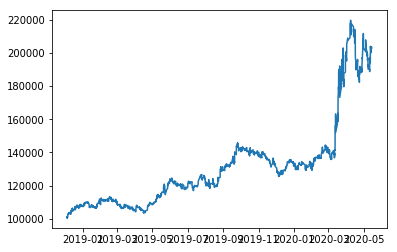

In [10]:
plt.plot(df.money)

In [ ]:
profit_compound = dict()
profit_simple = dict()
for i in tickers:
    try:
        df = BB_strat_backtest(i)
        a1 = ((df['money'].iloc[-1]) - 100000)/1000
        a2 = (sum(df['2'])/df['0'].iloc[0])*100
        profit_simple[i] = a2
        profit_compound[i] = a1
        print(i)
    except:
        pass

In [ ]:
df1 = pd.DataFrame(profit_simple).T
df2 = pd.DataFrame(profit_compound).T
df1.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str('profit_simple') + '_BB.csv')
df2.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str('profit_compound') + '_BB.csv')        

In [ ]:
profit_simple

In [ ]:
result = pd.DataFrame(index = profit_simple.keys())

In [ ]:
result['simple'] = profit_simple.values()

In [ ]:
result['compound']=  profit_compound.values()

In [ ]:
result.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str('result') + '_BB.csv')